In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

In [53]:
g4_tool = "regex"

In [54]:
G4_PATH = f"../results/{g4_tool}_g4_distribution.csv"
    
# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Archaea': '#e78ac3',
    'Eukaryota': '#8da0cb',
}

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'

In [55]:
# species data
df_species = pd.read_csv("../results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "GC Percentage", "Taxa"]]
df_species = df_species.replace('na', np.nan)
df_species["GC Percentage"] = df_species["GC Percentage"].astype(float)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.head()

,Accession,Genome Size,GC Percentage,Taxa,Domain
0,GCA_000002515.1,10689156.0,38.5,fungi,Eukaryota
1,GCA_031844645.1,6733472.0,61.0,bacteria,Bacteria
2,GCA_958295725.1,3665566.0,67.0,bacteria,Bacteria
3,GCA_000002765.3,23292622.0,19.0,protozoa,Eukaryota
4,GCA_000006645.1,4701745.0,47.5,bacteria,Bacteria


In [56]:
# g4 data
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count", "total_g4_length"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
df_g4["total_g4_length"] = df_g4["total_g4_length"].astype(float)

# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
df_g4.head()

# remove metagenomes and other taxa
df_g4 = df_g4[df_g4['Taxa'] != 'metagenomes']
df_g4 = df_g4[df_g4['Taxa'] != 'other']

[   3.94132291 -133.85858554]


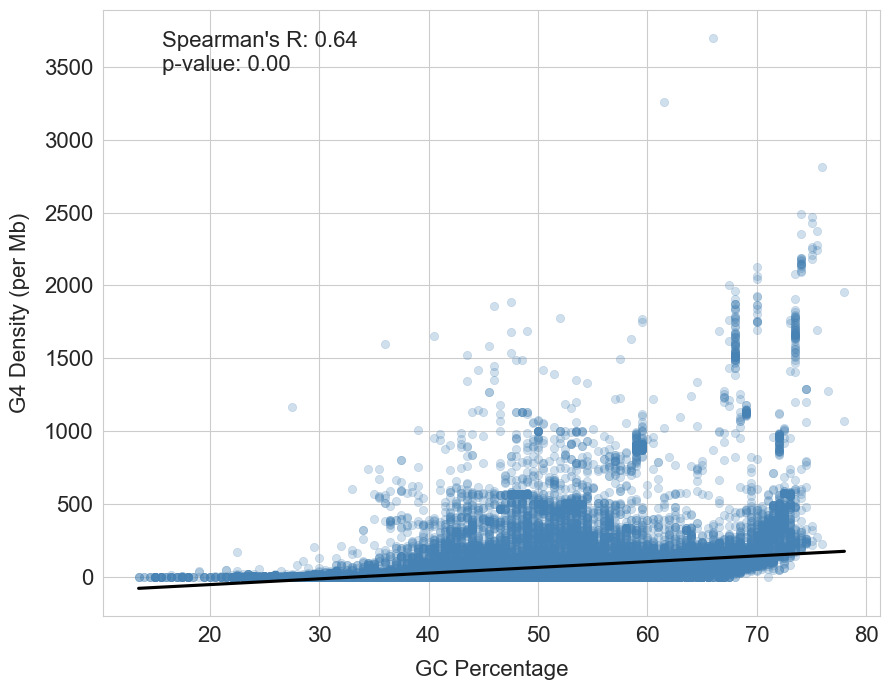

In [57]:
# scatter plot of G4 density vs GC percentage
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(
    x="GC Percentage", 
    y="G4 Density (per Mb)", 
    alpha=0.25, 
    color='steelblue', 
    edgecolor='steelblue', 
    data=df_g4, 
    ax=ax
)
sns.regplot(
    data=df_g4,
    x="GC Percentage",
    y="G4 Density (per Mb)", 
    scatter=False,
    color='black', 
    ax=ax
)
# formatting
plt.xlabel("GC Percentage", fontsize=16, labelpad=10)
plt.ylabel("G4 Density (per Mb)", fontsize=16, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.ticklabel_format(style='plain')
plt.tight_layout()

# spearman correlation coefficient
corr, p = spearmanr(df_g4['GC Percentage'], df_g4['G4 Density (per Mb)'])
ax.text(0.075, 0.9, f"Spearman's R: {corr:.2f}\np-value: {p:.2f}", transform=ax.transAxes, fontsize=16)
plt.savefig(f"../plots/g4_density_vs_gc_content_{g4_tool}.png")

# slope and intercept
print(np.polyfit(df_g4['GC Percentage'], df_g4['G4 Density (per Mb)'], 1))

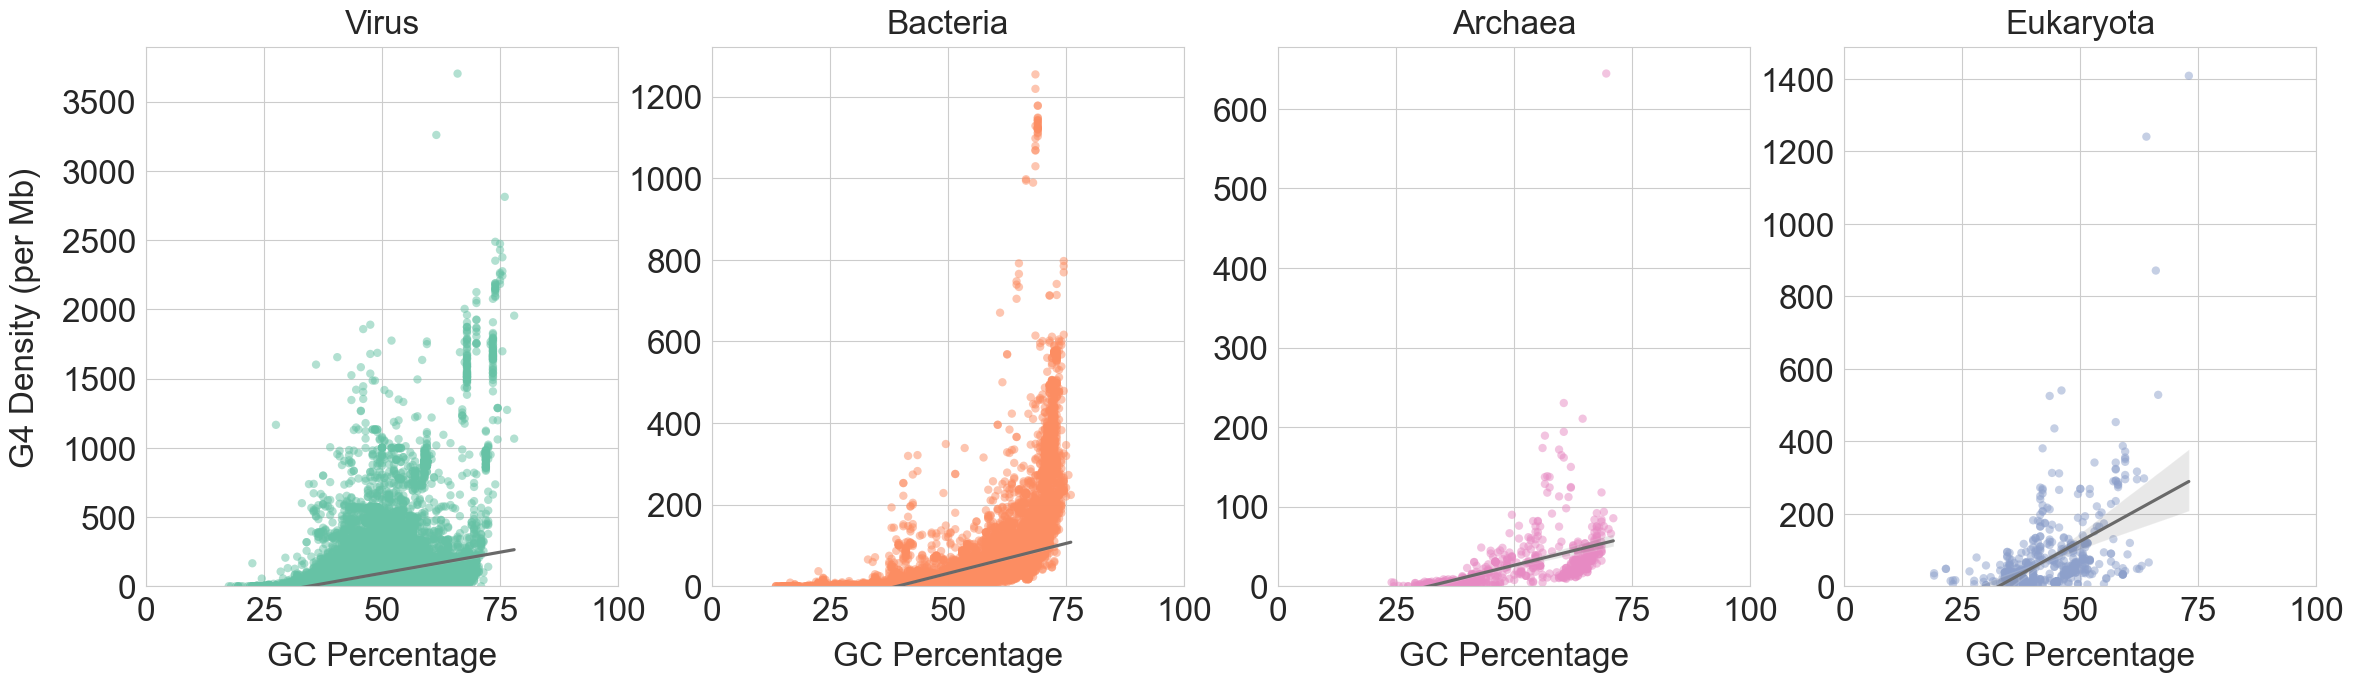

In [60]:
# plot the distribution of GC Percentage vs G4 density (per Mb) for each domain
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
domains = ['Virus', 'Bacteria', 'Archaea', 'Eukaryota']
for i in range(4):
	sns.scatterplot(
		data=df_g4[df_g4['Domain'] == domains[i]],
		x="GC Percentage",
		y="G4 Density (per Mb)",
		alpha=0.5, edgecolor='none',
		ax=ax[i],
		color=color_map[domains[i]]
	)
	sns.regplot(
		data=df_g4[df_g4['Domain'] == domains[i]],
		x="GC Percentage",
		y="G4 Density (per Mb)",
		ax=ax[i],
		scatter=False,
		color='dimgrey'
	)

	# set title for each subplot
	ax[i].set_title(domains[i], fontsize=24, pad=10)
	# set axis labels for each subplot
	ax[i].set_xlabel('GC Percentage', fontsize=24, labelpad=10)
	# specify x axis limits for each subplot
	ax[i].set_xlim(0, 100)
	# set tick font size
	ax[i].tick_params(axis='both', which='major', labelsize=24)
	# specify y axis limits for each subplot
	ax[i].set_ylim(bottom=0)
	# set y label only for leftmost subplot
	if i == 0:
		ax[i].set_ylabel('G4 Density (per Mb)', fontsize=24, labelpad=15)
	else:
		ax[i].set_ylabel('')

plt.savefig(f"../plots/gc_percentage_g4_density_domain_{g4_tool}.png")

In [59]:
# get correlation coefficient and p-values for each domain
domains = ['Virus', 'Bacteria', 'Archaea', 'Eukaryota']
for domain in domains:
	domain_data = df_g4[df_g4['Domain'] == domain]
	corr, p = spearmanr(domain_data['GC Percentage'], domain_data['G4 Density (per Mb)'])
	print(f"{domain}: r={corr:.2f}, p={p:.2f}")

Virus: r=0.51, p=0.00
Bacteria: r=0.92, p=0.00
Archaea: r=0.81, p=0.00
Eukaryota: r=0.44, p=0.00
